# Below is with Generic Likelihood Model Class

In [1]:
import os, csv, random
from __future__ import division
from matplotlib import  pyplot as plt
from memory_profiler import profile
from collections import deque
import numpy as np
import scipy.io as sio
from scipy import stats
import seaborn as sns
from scipy import optimize
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline
%load_ext memory_profiler

In [2]:
class Pairwise(GenericLikelihoodModel):
    
    
    def __init__(self, endog, exog=None, **kwds):
        super(Pairwise, self).__init__(endog, exog, **kwds)
        self.rank =  deque([[1],[1]])
        

    def nloglikeobs(self, params):
        
        out = 1
        pairs = self.endog
        w = params
        
        for pair in pairs:
            out *= 1/(1+np.exp(w[pair[1]] - w[pair[0]]))   
            
        return -np.log(out)
    
    
    def score(self, params):
        self.rank.popleft()
        w = params
        pairs = self.endog
        grad = []
        for i in range(len(w)):
            grad.append(self.calc_gradient(pairs, w, i))
        
        self.rank.append(grad)
        
        return np.array(grad)
    
        
    def calc_gradient(self,pairs, w, w_i):
        gradient = 0

        for pair in pairs:
            if w_i == pair[0]:
                out = -1
            elif w_i == pair[1]:
                out = 1  
            else:
                out = 0

            gradient -= out / (1/(np.exp(w[pair[1]]-w[pair[0]]) + 0.00001) +1 )
            
        return gradient
    
    
    def fit(self, start_params=None, maxiter=1000, maxfun=5000):  
        return super(Pairwise, self).fit(start_params=start_params, 
                                         method='nm', 
                                         maxiter=maxiter, 
                                         maxfun=maxfun)

In [3]:
a = [[5],[6]]
a.pop()

[6]

# Generate Data randomly

In [4]:
def compare_rank(video_score, results, verbose=False, hist=False, pct=100):
    true_order = np.array(video_score).argsort()
    true_ranks = true_order.argsort()
    
    temp_o = np.array(results).argsort()
    temp_r = temp_o.argsort()

    resolution = 0.1
    video_score_results = np.round(np.array(results)/resolution)*resolution
    
    if verbose:
        print 'Result Order \t True Order \t Result Score \t Ture Score'
        for i in range(len(temp_r)):
            print temp_r[i], '\t\t', true_ranks[i], '\t\t', video_score_results[i], '\t\t', video_score[i]
            
    if hist:
        
        diff = np.abs(temp_r - true_ranks)
        plt.hist(diff, alpha=0.5)
#         plt.title('Histogram of ranking difference between truth and predictions with %d percent of pairs' % pct)

In [26]:
video_num = 20

video_score = np.random.uniform(-5,5,video_num)
resolution = 0.1
video_score = np.round(video_score/resolution)*resolution

pairs_truth = []

for i in range(len(video_score)-1):
    for j in range(i+1, len(video_score)):
        if video_score[i] > video_score[j]:
            pairs_truth.append((i,j))
        else:
            pairs_truth.append((j,i))
            
total_pairs = len(pairs_truth)
print total_pairs

190


In [27]:
model = Pairwise(pairs_truth)
w_init = np.zeros(video_num)
results = model.fit(w_init, maxiter=100000, maxfun=50000)

Optimization terminated successfully.
         Current function value: 0.406658
         Iterations: 8003
         Function evaluations: 9927


In [28]:
res = model.rank[0]
compare_rank(video_score, results.params, True)

Result Order 	 True Order 	 Result Score 	 Ture Score
4 		1 		-0.4 		-4.6
5 		8 		-0.2 		-1.5
9 		7 		0.5 		-1.9
13 		16 		1.3 		4.2
14 		15 		1.3 		3.3
0 		0 		-3.8 		-5.0
12 		18 		1.3 		4.6
10 		9 		0.7 		-1.3
17 		11 		2.3 		-0.2
2 		3 		-2.9 		-4.1
3 		10 		-0.4 		-0.9
1 		4 		-3.0 		-3.6
8 		14 		0.5 		2.5
7 		2 		0.1 		-4.1
6 		5 		0.1 		-3.6
19 		19 		3.4 		5.0
18 		12 		2.6 		-0.1
16 		17 		1.8 		4.5
15 		13 		1.6 		0.5
11 		6 		0.7 		-2.7


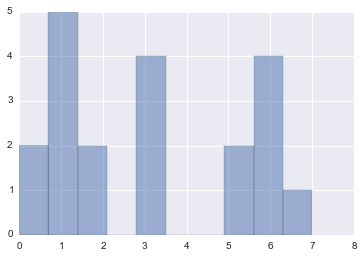

In [29]:
compare_rank(video_score, results.params, False, True)

Current evaluating with 190 test pairs
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 12429
         Function evaluations: 16097
Current evaluating with 152 test pairs
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 2858
         Function evaluations: 4041
Current evaluating with 114 test pairs
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 13514
         Function evaluations: 17419
Current evaluating with 76 test pairs
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1302
         Function evaluations: 2059
Current evaluating with 38 test pairs
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 2722
         Function evaluations: 3860


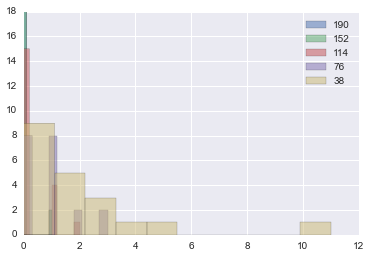

In [32]:
video_num = 20
video_score = np.random.uniform(-5,5,video_num)
resolution = 0.1
video_score = np.round(video_score/resolution)*resolution

pairs_truth = []

for i in range(len(video_score)-1):
    for j in range(i+1, len(video_score)):
        if video_score[i] > video_score[j]:
            pairs_truth.append((i,j))
        else:
            pairs_truth.append((j,i))
            
total_pairs = len(pairs_truth)  


# num_test_pairs = (np.array((0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1))*total_pairs).astype(int)
num_test_pairs = (np.array((1,0.8,0.6,0.4,0.2))*total_pairs).astype(int)
# num_test_pairs = (np.array((0.1, 0.2, 0.3))*total_pairs).astype(int)
num_to_be_flipped = np.array((0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5))


for test_pair_num in num_test_pairs:
    print 'Current evaluating with %d test pairs' % test_pair_num
    test_pairs = [pairs_truth[i] for i in random.sample(range(total_pairs), test_pair_num)]
    model = Pairwise(test_pairs)
    w_init = np.random.uniform(-5,5,video_num)
    results = model.fit(w_init, maxiter=100000, maxfun=50000)
    compare_rank(video_score, results, False, True, int(test_pair_num/total_pairs*100))
plt.legend([str(i) for i in num_test_pairs])

Current evaluating with 0.050000 to flip
Optimization terminated successfully.
         Current function value: 0.336758
         Iterations: 8938
         Function evaluations: 11296
Current evaluating with 0.150000 to flip
Optimization terminated successfully.
         Current function value: 0.462347
         Iterations: 18649
         Function evaluations: 23413
Current evaluating with 0.250000 to flip
Optimization terminated successfully.
         Current function value: 0.669138
         Iterations: 15997
         Function evaluations: 20064
Current evaluating with 0.400000 to flip
Optimization terminated successfully.
         Current function value: 0.639298
         Iterations: 16954
         Function evaluations: 21270
Current evaluating with 0.600000 to flip
Optimization terminated successfully.
         Current function value: 0.626728
         Iterations: 18208
         Function evaluations: 22781


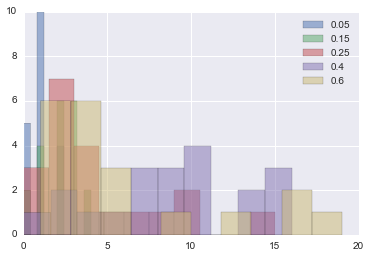

In [40]:
video_num = 20
video_score = np.random.uniform(-5,5,video_num)
resolution = 0.1
video_score = np.round(video_score/resolution)*resolution

pairs_truth = []

for i in range(len(video_score)-1):
    for j in range(i+1, len(video_score)):
        if video_score[i] > video_score[j]:
            pairs_truth.append((i,j))
        else:
            pairs_truth.append((j,i))
            
total_pairs = len(pairs_truth)  



num_test_pairs = total_pairs
num_to_be_flipped = np.array((0.05, 0.15, 0.25,  0.4, 0.6))


for to_flip in num_to_be_flipped:
    print 'Current evaluating with %f to flip' % to_flip
    
    test_pairs_with_error = pairs_truth
    
    num_to_flip = int(num_test_pairs*to_flip)
    
    for i in random.sample(range(num_test_pairs), num_to_flip):
        test_pairs_with_error[i] = (pairs_truth[i][1],pairs_truth[i][0])
        
    model = Pairwise(test_pairs_with_error)
    w_init = np.random.uniform(-5,5,video_num)
    results = model.fit(w_init, maxiter=100000, maxfun=50000)
    compare_rank(video_score, results, False, True, int(test_pair_num/total_pairs*100))
plt.legend([str(i) for i in num_to_be_flipped])

In [11]:
from my_func import my_func

In [19]:
%mprun -f my_func my_func()

('',)


In [18]:
%%memit l=range(1000000)
: len(l)

SyntaxError: invalid syntax (<string>, line 1)

# Read data from file

In [3]:
def append_pair(comp, name1, name2, name_to_num):
    if comp == '-1':
        return((name_to_num[name2], name_to_num[name1]))
    if comp == '1':
        return((name_to_num[name1], name_to_num[name2]))

In [4]:
# Used to store video name and their corresponding index
name_to_num = dict()
# Here pairs will be a list of 5 lists correpesonding to each of the 5 traits
pairs = [[],[],[],[],[]]

j = 0
path = './data'
files = [f for f in os.listdir(path) if f.endswith('.csv')]
for file in files:
    with open('./data/'+file, 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ')
        for row in reader:
            if not row[1] in name_to_num:
                name_to_num[row[1]] = j
                j += 1
            if not row[2] in name_to_num:
                name_to_num[row[2]] = j
                j += 1
            for i in range(3,8):
                pair = append_pair(row[i],row[1],row[2],name_to_num)
                if pair != None:
                    pairs[i-3].append(pair)
video_num = j

In [5]:
name_to_num

{'../videos/-DXzJ6jxhOM.001.mp4': 28,
 '../videos/-_e7j8_W77g.000.mp4': 25,
 '../videos/-yuIc0nWsvs.000.mp4': 0,
 '../videos/1fvBSv1cNUU.000.mp4': 26,
 '../videos/1oEY1QQ_6ss.001.mp4': 8,
 '../videos/2IC74dLuG_U.000.mp4': 3,
 '../videos/2lCNSi1JD7w.001.mp4': 22,
 '../videos/2ltp6TYwjJE.001.mp4': 6,
 '../videos/3L1qnlifDk8.001.mp4': 19,
 '../videos/3NHxfy58SqA.000.mp4': 14,
 '../videos/3jdbKrQKw2s.002.mp4': 20,
 '../videos/4GTKcoCJHBs.002.mp4': 4,
 '../videos/4ZBHzdkFDrY.001.mp4': 18,
 '../videos/4ssTy-NvTLg.000.mp4': 17,
 '../videos/5izh7-zFFdg.001.mp4': 9,
 '../videos/6Z5NhCtqEkw.002.mp4': 27,
 '../videos/6yWbfD71gH4.002.mp4': 5,
 '../videos/84ieZEdwBN8.001.mp4': 16,
 '../videos/8CZEYuJQPX8.002.mp4': 13,
 '../videos/9iKnGQiOSt0.002.mp4': 10,
 '../videos/9oVaec0OVIg.002.mp4': 11,
 '../videos/AdLIA3nYSkU.001.mp4': 15,
 '../videos/B6QtDf9sIvQ.001.mp4': 21,
 '../videos/BBWnOheRxss.000.mp4': 24,
 '../videos/BOAekq80wBc.001.mp4': 29,
 '../videos/CG8vq7r1RqM.000.mp4': 23,
 '../videos/D69eTQ3

In [60]:
# estimated_for_each_trait = []
# for i in range(5):
#     print 'Evaluating trait %d', i+1
#     model = Pairwise(pairs[i])
#     w_init = np.random.uniform(-1000,1000,30)
#     results = model.fit(w_init, maxiter=1000000, maxfun=1000000)
#     estimated_for_each_trait.append(results.params)

In [49]:
model = Pairwise(pairs[0])
w_init = np.zeros(30)
results = model.fit(w_init, maxiter=1000000, maxfun=1000000)

Optimization terminated successfully.
         Current function value: 0.585953
         Iterations: 17793
         Function evaluations: 20971


In [ ]:
# Multi processor parallel code. Not very successful

from multiprocessing import Pool

estimated_for_each_trait = {}

def f(i):
    print 'Evaluating trait %d', i+1
    model = Pairwise(pairs[i])
    w_init = np.random.uniform(-5,5,video_num)
    results = model.fit(w_init, maxiter=1000000, maxfun=1000000)
    estimated_for_each_trait[str(i)] = results.params
    return estimated_for_each_trait

def mp_handler():
    p = multiprocessing.Pool(8)
    p.map(f, [0,1,2,3,4])
    
mp_handler()

In [21]:
for pair in pairs[3]:
    if (pair[0] == 3 and pair[1] == 6) or (pair[0] == 6 and pair[1] == 3)     or (pair[0] == 3 and pair[1] == 4)     or (pair[0] == 4 and pair[1] == 3)     or (pair[0] == 4 and pair[1] == 6)    or (pair[0] == 6 and pair[1] == 4):
        print pair
    

(3, 6)
(4, 6)
(4, 3)


In [14]:
print pairs[0][0]

(1, 0)
